## Field-of-View of FACT

The field-of-view (FoV) of FACT derived from its longitude and latitude can tell us a lot about the data we measure from different sources. Immediately apparent are the zenith angle the source culminates at, the time-window of observation each year, and how the moon will affect the observation of each source.

This notebook will plot the FoV of FACT for today or any given day, in addition to frequently observed sources and the ecliptic.

In [2]:
# Import packages and notebook set-up
from astropy.coordinates import get_moon
from astropy.time import Time
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

The defining properties for the FoV are the longitude and latitude coordinates of FACT, as well as the date.

In [3]:
# FACT coordinates
latitude = 28 + 45/60 + 41.9/3600  # 28°45'41.9" N
longitude = -(17 + 53/60 + 28.0/3600) # 17°53'28.0" W

# Date of Observation: Today
# date = datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
# Alternatively, we can specify any date using ISO representation, eg
date = '2012-08-01 15:00:0'

# Calculate apparent local sidereal time at FACT coordinates
time = Time(date, format='iso', scale='utc', location=(longitude, latitude))
lst = float(time.sidereal_time('apparent').to_string(unit='degree', decimal=True))

# Short status update
print('At time {!s}, the local sidereal time for FACT at coordinates\
 (17°53\'28.0" W, 28°45\'41.9" N) is {:.2f}°'.format(date, lst))

# The conversions below require latitude and lst in radians
latitude = np.radians(latitude)
lst = np.radians(lst)

At time 2012-08-01 15:00:0, the local sidereal time for FACT at coordinates (17°53'28.0" W, 28°45'41.9" N) is 157.73°


/usr/local/lib/python3.5/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


We can now plot the FACT FoV at the given date using the [Mollweide projection](https://en.wikipedia.org/wiki/Mollweide_projection). We define a helper function to plot
(RA, Dec) coordinates onto the Mollweide projection, following [this guide](http://balbuceosastropy.blogspot.de/2013/09/the-mollweide-projection.html).

The FoV is calculate using the conversion from horizontal to equatorial coordinates. It is assumed that FACT can observe [0, 360) degree in azimuth and [0, 90] degree in altitude in the horizontal system. In reality, objects below 30 degree altitude are rarely observable. 

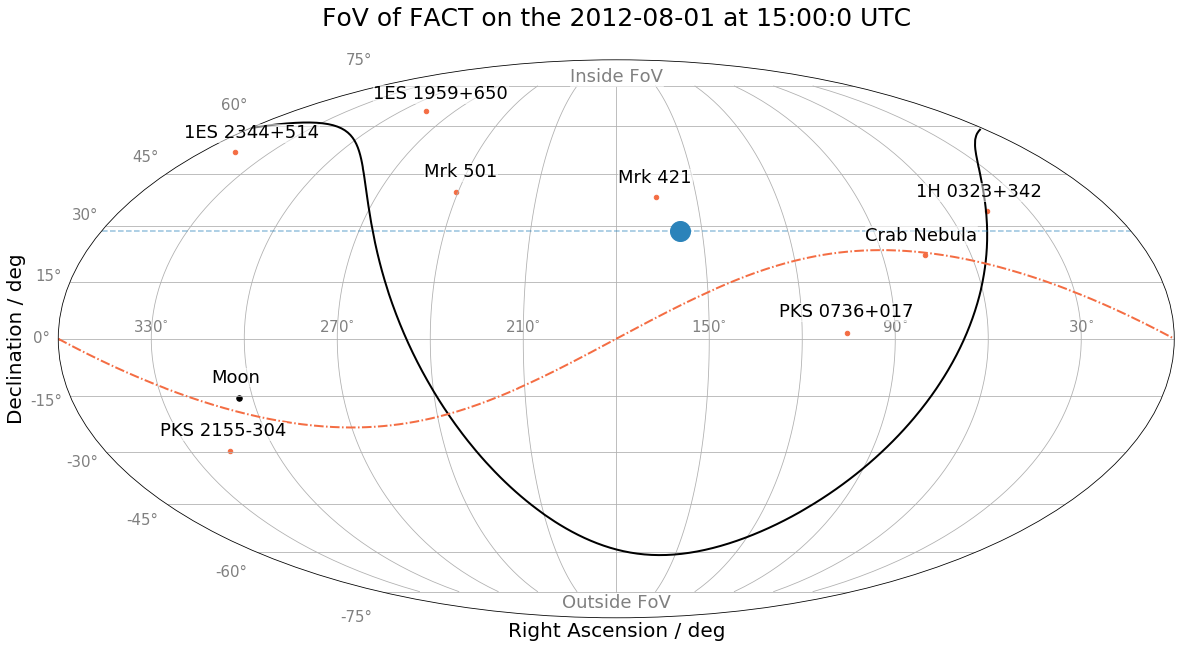

In [4]:
# Define two helper functions
def ra_dec_to_mwd(RA, Dec):
    '''
    RA, Dec are the coordinates in degrees
    '''
    ra_origin = 180 # We want 180° RA in the middle of the plot
    ra = np.remainder(RA + 360 - ra_origin, 360) # shift RA values
    ra = np.array(ra)
    ra[ra > 180] -= 360    # scale conversion to [-180, 180]
    ra *= -1    # Using astronomical convention: East to the left
    return np.radians(ra), np.radians(Dec)

def plot_source(RA, dec, name, color='#f46d43', s=20):
    # Converts source coordinates to mollweide projection, 
    # annotates the dot with the source's name
    ra, dec = ra_dec_to_mwd(RA, dec)
    ax.scatter(ra, dec, marker='o', color=color, s=s)
    # Every annotation has a transparent white box underneath
    # to improve readability
    ax.annotate(name, (ra, dec + 3 * np.pi / 180), size=18, ha='center', va='bottom',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', pad=0))
    
# Initiliaze the figure and axis instances
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': 'mollweide'})

# ----------------
# Add FACT FoV: We compute the equatorial coordinates of the FoV in the horizontal system

# Define horizontal FoV
azimuth = np.linspace(0, 2*np.pi, 200)  # [0, 360) degree, but for plotting purposes we 
                                        # include the last point
altitude = 0.                           # The FoV is defined by the horizon

# Calculate RA and Dec
declination = np.arcsin(np.sin(latitude) * np.sin(altitude)
                        + np.cos(latitude) * np.cos(altitude) * np.cos(azimuth))

# For the RA, we have to compute the hour angle first. We use the arctan2 function to
# choose the correct quadrant
x = -np.sin(azimuth) * np.cos(altitude) / np.cos(declination)
y = (np.sin(altitude) - np.sin(declination) * np.sin(latitude)) / (np.cos(declination) * np.cos(latitude))
hour_angle = np.arctan2(x, y)
right_ascension = lst - hour_angle

# For drawing purposes, we sort the output coordinates by right_ascension.
# Then we perform some black magic to convert between tuples, lists, and zip objects to plot the FoV
plot_ra, plot_dec = ra_dec_to_mwd(np.degrees(right_ascension), np.degrees(declination))
ax.plot(*zip(*[(ra, dec) for ra, dec in sorted(zip(plot_ra, plot_dec))]), color='black', lw=2)

# ----------------
# Add FACT's zenith: Sources close to this point in declination will culminate
# close to the zenith, which is important for the data quality
# The zenith moves along the declintaion=latitude line

dec_z = latitude
ra_z = lst
ax.plot(*ra_dec_to_mwd(np.degrees(ra_z), np.degrees(dec_z)),'o',ms=20, color='#2b83ba')

ax.plot(np.linspace(-np.pi, np.pi, 2), np.ones(2)*latitude, '--', alpha=0.5, color='#2b83ba')

# -----------------
# Add sources, using the helper function defined above
sources = {
    # Name:            (RA, Dec)
    'Mrk 501':         ((16 + 53/60 + 52/3600)*15, 39 + 45/60 + 38/3600),
    'Mrk 421':         ((11 + 4 / 60+ 27/3600)*15, 38 + 12/60 + 32/3600),
    'Crab Nebula':     ((5 + 34/60 + 32/3600)*15, 22 + 0 + 52/3600),
    'PKS 2155-304':    ((21 + 58/60 + 52/3600)*15, -30 + 13/60 + 18/3600),
    '1ES 1959+650':    ((19 + 59/60 + 60/3600)*15, 65 + 8/60 + 55/3600),
    '1ES 2344+514':    ((23 + 47/60 + 5/3600)*15, 51 + 42/60 + 17/3600), 
    '1H 0323+342':     ((3 + 24/60 + 41/3600)*15, 34 + 10/60 + 46/3600),
    'PKS 0736+017':    ((7 + 39/60 + 18/3600)*15, 1 + 37/60 + 5/3600)
}

for source, coordinates in sources.items():
    plot_source(*coordinates, source)


# ----------------
# Add the ecliptic
epsilon = 23.4392 * np.pi / 180
alpha = np.arange(-180 * np.pi / 180, 180. * np.pi / 180, 0.01)
delta = np.array([np.arctan(np.sin(a)*np.tan(epsilon)) for a in alpha])
ax.plot(alpha, delta, ls='-.', lw=2, color='#f46d43')

# ---------------
# Add position of Moon

moon = get_moon(time)
plot_source(float(moon.ra.to_string(unit='degree', decimal=True)),
            float(moon.dec.to_string(unit='degree', decimal=True)), 'Moon',
           color='black', s=30)
# ---------------
# Set-up the labels, colors, and sizes

# Tick labels
tick_labels = [r'330$^{\circ}$', '', r'270$^{\circ}$', '', r'210$^{\circ}$', '', r'150$^{\circ}$', '', r'90$^{\circ}$', '', r'30$^{\circ}$']
ax.set_xticklabels(tick_labels, fontsize=15)
for label in ax.get_yticklabels():
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='gray') 
ax.tick_params(axis='y', colors='gray')

# Axis labels
ax.set_xlabel('Right Ascension / deg', fontsize=20)
ax.set_ylabel('Declination / deg', fontsize=20)

# Grid and some explanations
plt.grid(True)
plt.title('FoV of FACT on the %s at %s UTC\n' % 
          (date.split(' ')[0],  date.split(' ')[1]), fontsize=25);
ax.annotate('Inside FoV', ra_dec_to_mwd(180, 75), size=18, ha='center', va='bottom',
            color='gray', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', pad=0))
ax.annotate('Outside FoV', ra_dec_to_mwd(180, -85), size=18, ha='center', va='bottom',
            color='gray', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', pad=0));

In the plot above, the black line marks the FoV. The sky above the line is visible, while the part below is blocked by the Earth. Over the course of one day, the FoV moves towards larger RA due to Earth's rotation. Since the sidereal day is 4 minutes shorter than the solar day, after 24 hours the FoV will be shifted by about 1° towards larger RA.

The orange, dashed line marks the ecliptic plane. Objects close to this line in declination will be most affected by noise due to moon light.

The blue, dashed line marks FACT's zenith. The distance in declination of the sources to the zenith shows the zenith angle at upper culmination of the source as seen from FACT. E.g.: The Crab Nebula culminates at about 28°-22° = 6° zenith angle. The blue dot on this line marks the current location of the zenith. It shifts towards larger right ascension with time.